# Prediction of number of deaths/infected through COVID-19

This predictions are done on 29/03/2020, using data until this date.

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from datetime import datetime,timedelta

## Data

The data comes from here: https://github.com/CSSEGISandData/COVID-19/

In [21]:
df_recovered=pd.read_csv('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
df_recovered.head()


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,1,1,1,1,2,2,2,2,2,2
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,2,2,2,10,17,17,31,31,33,44
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,32,65,65,24,65,29,29,31,31,37
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,10
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
df_confirmed=pd.read_csv('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_confirmed.head()


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,24,40,40,74,84,94,110,110,120,170
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,76,89,104,123,146,174,186,197,212,223
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,139,201,230,264,302,367,409,454,511,584
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,88,113,133,164,188,224,267,308,334,370
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,2,2,3,3,3,4,4,5,7,7


In [23]:
df_dead=pd.read_csv('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
df_dead.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,0,1,1,1,2,4,4,4,4,4
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,2,2,4,5,5,6,8,10,10,11
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,15,17,17,19,21,25,26,29,31,35
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,0,1,1,1,1,3,3,3,6,8
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,2


## Data manipulation

So far, I pick up five different countries to study:

- China (The first one, and therefore the reference to compare to).
- Italy (One of the biggest ones, and much more similar in social, politics and size with other Europen countries).
- Spain
- France
- US (Summing all the data from all the states together).

In [24]:
df_confirmed.loc['WholeUS'] = df_confirmed[df_confirmed['Country/Region']=='US'].sum()
df_confirmed.loc[df_confirmed.index=='WholeUS','Country/Region']='WholeUS'
df_dead.loc['WholeUS'] = df_dead[df_dead['Country/Region']=='US'].sum()
df_dead.loc[df_dead.index=='WholeUS','Country/Region']='WholeUS'

In [25]:
df_confirmed.loc[df_confirmed.index=='WholeUS',:]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20
WholeUS,0,WholeUS,37.0902,-95.7129,1,1,2,2,5,5,...,25489,33276,43847,53740,65778,83836,101657,121478,140886,161807


In [26]:
df_confirmed[(df_confirmed['Country/Region']=='France') & (df_confirmed['Province/State'].isnull())]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20
116,NaN,France,46.2276,2.2137,0,0,2,3,3,3,...,14282,16018,19856,22304,25233,29155,32964,37575,40174,44550


In [27]:
def select_countries(df):
    df = df[(df['Country/Region']=='Spain') | (df['Country/Region']=='Italy') | 
                            ((df['Country/Region']=='France') & (df['Province/State'].isnull()))
                            |((df['Country/Region']=='China') & (df['Province/State']=='Hubei')) |
           (df['Country/Region']=='WholeUS')]
    return df

In [28]:
def prepare_dataframe(df,label='contagious'):
    """
    I create a new column "DayStart"+Country, which sets to 1 the day the number of contagious or deads equal the same as China on 1/22/20.
    This is done to be able to compare past curves (such as in China or Italy), with present ones (France, Spain or US)
    """
    if label=='contagious':
        nspain=43
        nfrance=42
        nitaly=34
        nus=44
    if label=='death':
        nspain=43
        nfrance=44
        nitaly=35
        nus=44
        
    df = df.set_index('Country/Region').drop(['Lat','Long','Province/State'],axis=1).T
    df = df.reset_index()
    df['DayStartChina']= df.index +1
    df['DayStartSpain']= df.index -nspain
    df['DayStartFrance']= df.index -nfrance
    df['DayStartItaly']= df.index -nitaly
    df['DayStartUS']= df.index -nus
    
    return df
        

In [29]:
df_contag  = select_countries(df_confirmed)
df_death  = select_countries(df_dead)

In [30]:
df_contag  = prepare_dataframe(df_contag,label='contagious')
df_death  = prepare_dataframe(df_death,label='death')

In [31]:
df_contag.head()

Country/Region,index,China,France,Italy,Spain,WholeUS,DayStartChina,DayStartSpain,DayStartFrance,DayStartItaly,DayStartUS
0,1/22/20,444,0,0,0,1,1,-43,-42,-34,-44
1,1/23/20,444,0,0,0,1,2,-42,-41,-33,-43
2,1/24/20,549,2,0,0,2,3,-41,-40,-32,-42
3,1/25/20,761,3,0,0,2,4,-40,-39,-31,-41
4,1/26/20,1058,3,0,0,5,5,-39,-38,-30,-40


## Model the data

As this is a Pandemic, we know it grows as an Exponential, until it reaches the inflexion point and it becomes a logistic function. I'm then going to consider both models for our analysis. 

In [32]:
def exponential_model(x,a,b,c):
    return a*np.exp(b*(x-c))

def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))


In [46]:
def plot_normalized_day0(df,label='Contagious',fit=True):
    
    fig = plt.figure(figsize=(10,12))
    ax = fig.add_subplot(1, 1, 1)

    
    plt.plot(df['DayStartSpain'][df['DayStartSpain']>0],df['Spain'][df['DayStartSpain']>0],'b*')
    plt.plot(df['DayStartFrance'][df['DayStartFrance']>0],df['France'][df['DayStartFrance']>0],'yo')
    plt.plot(df['DayStartUS'][df['DayStartUS']>0],df['WholeUS'][df['DayStartUS']>0],'ms')
    plt.plot(df['DayStartItaly'][df['DayStartItaly']>0],df['Italy'][df['DayStartItaly']>0],'gv')
    plt.plot(df['DayStartChina'],df['China'],'r+')


    if fit:
        xxS = np.array(df['DayStartSpain'][df['DayStartSpain']>0])
        yyS = np.array(df['Spain'][df['DayStartSpain']>0])
        xxSi=xxS[xxS<20]
        yySi=yyS[xxS<20]
        popt, pcov = curve_fit(exponential_model, xxSi, yySi, bounds=([-100,-1.,-100], [100., 1., 100.]))        
        poptS, pcovS = curve_fit(logistic_model, xxS, yyS, bounds=([4,10.,100], [10., 100., 100000.]))
        plt.plot(xxSi, exponential_model(xxSi, *popt), 'b-')#
        plt.plot(xxS, logistic_model(xxS, *poptS), 'b--')#
        print('Spain Exponential fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
        print('Spain Logistic fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(poptS))

        xxF = np.array(df['DayStartFrance'][df['DayStartFrance']>0])
        yyF = np.array(df['France'][df['DayStartFrance']>0])
        popt, pcov = curve_fit(exponential_model, xxF, yyF, bounds=([-100,-1.,-100], [100., 1., 100.]))
        plt.plot(xxF, exponential_model(xxF, *popt), 'y-')#
        poptF, pcovF = curve_fit(logistic_model, xxF, yyF, bounds=([4,10.,100], [10., 100., 100000.]))
        plt.plot(xxF, logistic_model(xxF, *poptF), 'y--')#
        print('France Exponential fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
        print('France Logistic fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(poptF))

        xxW = np.array(df['DayStartUS'][df['DayStartUS']>0])
        yyW = np.array(df['WholeUS'][df['DayStartUS']>0])
        popt, pcov = curve_fit(exponential_model, xxW, yyW, bounds=([-100,-1.,-100], [100., 1., 100.]))
        plt.plot(xxW, exponential_model(xxW, *popt), 'm-')#
        poptW, pcovW = curve_fit(logistic_model, xxW, yyW, bounds=([1,10.,100], [10., 100., 1000000.]))
        plt.plot(xxW, logistic_model(xxW, *poptW), 'm--')#
        print('US Exponential fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
        print('US Logistic fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(poptW))

        xxI = np.array(df['DayStartItaly'][df['DayStartItaly']>0])
        yyI = np.array(df['Italy'][df['DayStartItaly']>0])
        xxIi=xxI[xxI<20]
        yyIi=yyI[xxI<20]
        popt, pcov = curve_fit(exponential_model, xxIi, yyIi) 
        plt.plot(xxIi, exponential_model(xxIi, *popt), 'g-')
        poptI, pcovI = curve_fit(logistic_model, xxI, yyI, bounds=([4,10.,100], [10., 100., 100000.]))
        plt.plot(xxI, logistic_model(xxI, *poptI), 'g--')#
        print('Italy Exponential fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
        print('Italy Logistic fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(poptI))

        xxC = np.array(df['DayStartChina'])
        yyC = np.array(df['China'])
        xxCi=xxC[xxC<20]
        yyCi=yyC[xxC<20]
        popt, pcov = curve_fit(exponential_model, xxCi, yyCi) 
        plt.plot(xxCi, exponential_model(xxCi, *popt), 'r-')
        poptC, pcovC = curve_fit(logistic_model, xxC, yyC, bounds=([4,10.,100], [10., 100., 100000.]))
        plt.plot(xxC, logistic_model(xxC, *poptC), 'r--')#
        print('China Exponential fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
        print('China Logistic fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(poptC))

    ax.set_yscale('log')
    plt.xticks(rotation=45)
    plt.legend(['Spain','France','US','Italy','China','Spain Exponential Model','Spain Logistic Model',
                'France Exponential Model','France Logistic Model','US Exponential Model','US Logistic Model',
            'Italy Exponential Model', 'Italy Logistic Model','China Exponential Model', 'China Logistic Model'])
    plt.xlabel('Day from start of multiple '+label)
    plt.ylabel('N '+label)
    plt.show()

Spain Exponential fit: a=20.794, b=0.187, c=-21.683
Spain Logistic fit: a=4.000, b=19.856, c=100000.000
France Exponential fit: a=27.225, b=0.136, c=-28.822
France Logistic fit: a=5.128, b=24.749, c=79320.203
US Exponential fit: a=19.734, b=0.202, c=-20.979
US Logistic fit: a=3.301, b=22.539, c=264599.435
Italy Exponential fit: a=12.334, b=0.185, c=-22.123
Italy Logistic fit: a=4.153, b=24.083, c=100000.000
China Exponential fit: a=23.779, b=0.170, c=-23.587
China Logistic fit: a=4.261, b=19.694, c=67742.080


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


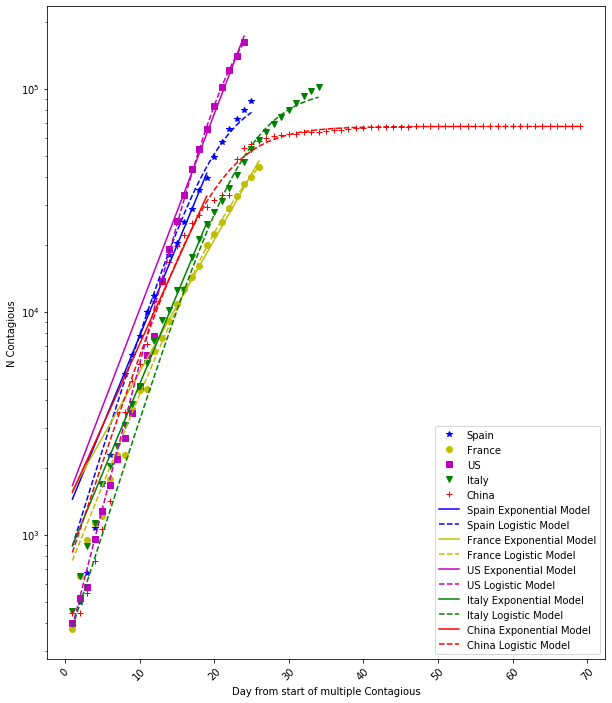

In [47]:
plot_normalized_day0(df_contag,label='Contagious')

Spain Exponential fit: a=12.257, b=0.255, c=-2.458
Spain Logistic fit: a=4.000, b=24.991, c=15626.638
France Exponential fit: a=12.796, b=0.190, c=-5.158
France Logistic fit: a=4.000, b=24.317, c=6351.016
US Exponential fit: a=9.845, b=0.239, c=-0.077
US Logistic fit: a=3.336, b=25.566, c=7777.148
Italy Exponential fit: a=8.738, b=0.224, c=-5.777
Italy Logistic fit: a=4.962, b=28.457, c=16014.588
China Exponential fit: a=11.917, b=0.160, c=-8.269
China Logistic fit: a=6.517, b=25.363, c=3129.096


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


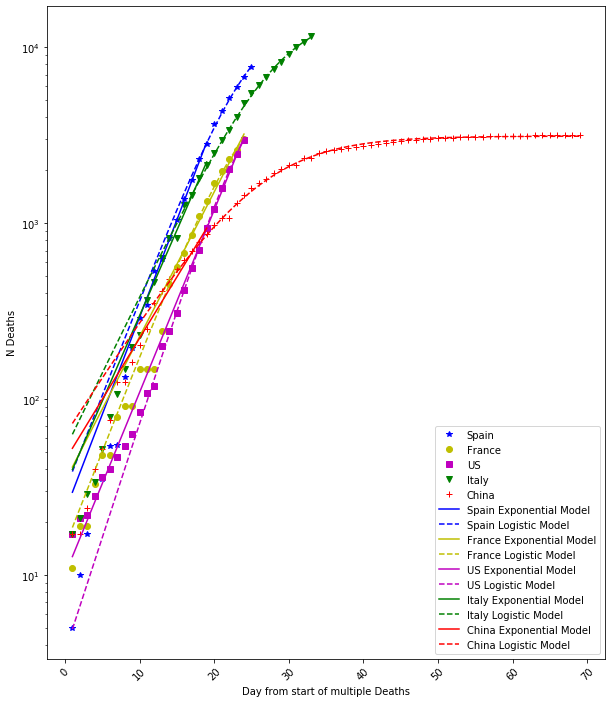

In [48]:
plot_normalized_day0(df_death,label='Deaths')

We have here fitted exponential and logistic models to the curves, and plot the above results. Let's notice than the deaths curves are much more realistic than the infected, as this depends very much on the existence of tests and different politics to measure those.

For the first time, countries such as Spain and France start to have a better logistic fit than exponential to date (31/03/2020).

## Extrapolation of the logistic model to 90 days after the first deaths/contagions

Let's use now only logistic models and assume there is going to be an inflection point of around ~25 days after the first contagions/deaths, to predict what will happen in 90 days after the first deaths / contagions.

Of course, this assumes that this inflection point is the same for all countries, and we know this will change depending on the strictness of the measurements that the different countries will take, so this is only a possible (and simple) scenario of what will happen.

In [54]:
def plot_extrapolated_logistic_model(df,label='Contagious',inflexion=25):
    
    fig = plt.figure(figsize=(10,12))
    ax = fig.add_subplot(1, 1, 1)

    
    plt.plot(df['DayStartSpain'][df['DayStartSpain']>0],df['Spain'][df['DayStartSpain']>0],'b*')
    plt.plot(df['DayStartFrance'][df['DayStartFrance']>0],df['France'][df['DayStartFrance']>0],'yo')
    plt.plot(df['DayStartUS'][df['DayStartUS']>0],df['WholeUS'][df['DayStartUS']>0],'ms')
    plt.plot(df['DayStartItaly'][df['DayStartItaly']>0],df['Italy'][df['DayStartItaly']>0],'gv')
    plt.plot(df['DayStartChina'],df['China'],'r+')

    xxPredictions = np.arange(0, 90)    
    
    xxS = np.array(df['DayStartSpain'][df['DayStartSpain']>0])
    yyS = np.array(df['Spain'][df['DayStartSpain']>0])
    popt, pcov = curve_fit(logistic_model, xxS, yyS, bounds=([4,inflexion-1,100], [10., inflexion+1, 1000000.]))       
#    popt, pcov = curve_fit(logistic_model, xxS, yyS, bounds=([4,1,100], [10., 100, 1000000.]))       
    plt.plot(xxPredictions, logistic_model(xxPredictions, popt[0],popt[1],popt[2]), 'b-')
    print('Spain',popt[0],popt[1],popt[2])
    
    xxF = np.array(df['DayStartFrance'][df['DayStartFrance']>0])
    yyF = np.array(df['France'][df['DayStartFrance']>0])
    popt, pcov = curve_fit(logistic_model, xxF, yyF, bounds=([4,inflexion-1,100], [10., inflexion+1, 100000.]))
#    popt, pcov = curve_fit(logistic_model, xxF, yyF, bounds=([4,1,100], [10., 100, 100000.]))
    plt.plot(xxPredictions, logistic_model(xxPredictions, popt[0],popt[1],popt[2]), 'y-')#
    print('France',popt[0],popt[1],popt[2])
    
    xxW = np.array(df['DayStartUS'][df['DayStartUS']>0])
    yyW = np.array(df['WholeUS'][df['DayStartUS']>0])
    popt, pcov = curve_fit(logistic_model, xxW, yyW, bounds=([4,inflexion-10,100], [10., inflexion+10, 1000000.])) 
#    popt, pcov = curve_fit(logistic_model, xxW, yyW, bounds=([4,1,100], [10.,100, 1000000.])) 
    plt.plot(xxPredictions, logistic_model(xxPredictions, *popt), 'm-')#
    print('US',popt[0],popt[1],popt[2])
    
    xxI = np.array(df['DayStartItaly'][df['DayStartItaly']>0])
    yyI = np.array(df['Italy'][df['DayStartItaly']>0])
    popt, pcov = curve_fit(logistic_model, xxI, yyI, bounds=([4,inflexion-1,100], [10., inflexion+1, 1000000.]))
#    popt, pcov = curve_fit(logistic_model, xxI, yyI, bounds=([4,1,100], [10., 100, 1000000.]))
    plt.plot(xxPredictions, logistic_model(xxPredictions, popt[0],popt[1],popt[2]), 'g-')#
    print('Italy',popt[0],popt[1],popt[2])
        
    xxC = np.array(df['DayStartChina'])
    yyC = np.array(df['China'])
    popt, pcov = curve_fit(logistic_model, xxC, yyC, bounds=([4,10,100], [10., 100, 100000.]))
#    popt, pcov = curve_fit(logistic_model, xxC, yyC, bounds=([4,1,100], [10., 100, 100000.]))
    plt.plot(xxPredictions, logistic_model(xxPredictions, popt[0],popt[1],popt[2]), 'r-')#
    print('China',popt[0],popt[1],popt[2])
    
    ax.set_yscale('log')
    plt.xticks(rotation=45)
    plt.legend(['Spain','France','US','Italy','China','Spain Logistic Model','France Logistic Model',
                'US Logistic Model','Italy Logistic Model', 'China Logistic Model'])
    plt.xlabel('Day from start of multiple '+label)
    plt.ylabel('N '+label)
    plt.show()

Spain 5.095749468604505 26.000000000000004 201893.53199076807
France 5.398397339128568 26.000000000000004 89886.3112867248
US 4.000000000000001 25.580333727622275 409274.48957756825
Italy 5.381794664876601 27.071460830928675 129024.10053775895
China 4.260773761165321 19.694247215695444 67742.07975657558


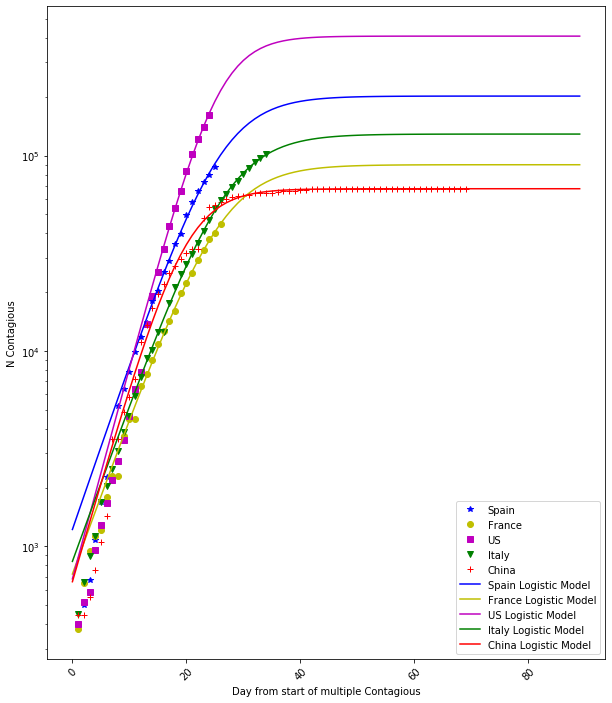

In [55]:
plot_extrapolated_logistic_model(df_contag,label='Contagious',inflexion=27)

Spain 4.1291689108953715 26.000000000000004 18059.62179478534
France 4.230591530710656 26.000000000000004 8093.703987346596
US 4.000000000000001 31.846369806089644 24649.684015699597
Italy 4.819102441913197 27.999999999999996 15369.700245778762
China 6.51743393759889 25.362585293212042 3129.095562564254


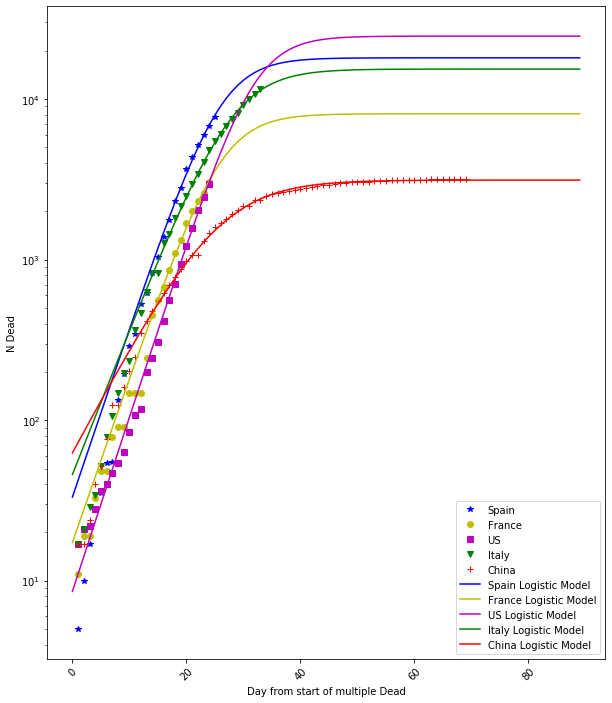

In [56]:
plot_extrapolated_logistic_model(df_death,label='Dead',inflexion=27)

I have used here, an inflexion point of 27 days for deaths, 26 for infected, based on the data from Italy.  This might change or not, based on the different measures each country takes. Based on this, the predictions are:

- ~20000 deaths in Spain, ~ 15000 in Italy, ~8000 in France and ~25000 in the US (where I had to set a much higher inflexion point of ~26+10). In China, the official number of deaths are ~2000.
- The number of infected would be of the order of ~200.000 per Spain, 120.000 per Italy, 80.000 per France and ~400.000 for the US. China would have 60000. 
- Of course these numbers are based on the official number of infected and deaths but, this is very related to the different politics in terms of testing people and counting deaths due to CoronaVirus. Probably this is just a inferior limit.

## Things to do

- Add more countries
- Normalize by the population of each country / number of bed in hospitals per country.
- Try different scenarios (such as inflexion points)
- Continously update with new data (and hopefully expect that this will change!)